# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

## Setup

### Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### User parameters

In [2]:
user_params = {
    'output_dir'  : './results',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/David Carruthers sample injection order.xlsx'
}

In [3]:
ls

check_original_prot_map.ipynb  DBTL1Recs4David_plotupdates.ipynb
choose_targets_sandbox.ipynb   get_Pputida_uniprot.ipynb
data/                          get_Pputida_unreviewed_uniprot.ipynb
DBTL1Recs4David.ipynb          results/
DBTL1Recs4David_local.ipynb    test_normalize.ipynb


### Useful functions

In [4]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

In [5]:
def plot_titers(df_prod, df_control_stat, product='Isoprenol'):
    "Plots isprenols titers as well as CV"
        
    ## create figure
    fig, ax = plt.subplots(figsize=(20,5))
    sns.set_style('white')

    ## Plot production in salmon color
    g = sns.scatterplot(data=df_prod,
                        x = 'Strain',
                        y = product,
                        color = 'salmon',
                        )
    ## Format isoprenol axis
    g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
    control_xval = np.where(df_prod.index.unique() == 'NT')
    plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
                df_control_stat[product], 
                marker = 'o', 
                color = 'none', 
                edgecolor = 'k', 
                label = 'control')
    
    ax.set_ylabel(product + " [uM]", fontsize=10, color='salmon')
    ax.set_xlabel("Strains", fontsize=10)
    
    ## Create %CV axis
    ax2 = plt.twinx()
    g2 = sns.scatterplot(data=df_prod,
                        x='Strain',
                        y='CV[%]', 
                        color='gray',
                        marker='o',
                        ax=ax2)
    plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],
                    marker='o', color="None",  edgecolor='k', label='Control'
                    )
    ax2.set_ylabel("CV[%]", fontsize=10, color='gray')
    sns.despine(left=True, bottom=True)
    ax.legend()
    ## Save figure
    fig.savefig(
        f"{user_params['output_dir']}/titer_cv.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

In [6]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df_targets.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [7]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

## Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [8]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'


We try connecting to the server with our login and password:

In [9]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [10]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

100%|██████████| 1182270/1182270 [01:00<00:00, 19413.29it/s]


There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [11]:
df['Protocol'].unique()

array(['Biolector', 'GC-FID', 'Global Proteomics'], dtype=object)

## Preprocess and inspect data

### Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [12]:
df['Protocol']=='Biolector'

0           True
1           True
2           True
3           True
4           True
           ...  
1182265    False
1182266    False
1182267    False
1182268    False
1182269    False
Name: Protocol, Length: 1182270, dtype: bool

In [13]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [14]:
df2.shape

(1033140, 15)

Let's just keep the basic data types:

In [15]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [16]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(420,
 array(['BL1A2_IY1586', 'BL1A3_IY1587', 'BL1A4_IY1588', 'BL1A5_IY1589',
        'BL1A6_IY1590', 'BL1A7_IY1591', 'BL1A8_IY1592', 'BL1B2_IY1586',
        'BL1B3_IY1587', 'BL1B4_IY1588', 'BL1B5_IY1589', 'BL1B6_IY1590',
        'BL1B7_IY1591', 'BL1B8_IY1592', 'BL1C2_IY1586', 'BL1C3_IY1587',
        'BL1C4_IY1588', 'BL1C5_IY1589', 'BL1C6_IY1590', 'BL1C7_IY1591',
        'BL1C8_IY1592', 'BL1D1_IY1593', 'BL1D2_IY1594', 'BL1D3_IY1595',
        'BL1D4_IY1596', 'BL1D5_IY1597', 'BL1D6_IY1452_pIY1081',
        '**BL1D7_IY1655', '**BL1D8_IY1656', '**BL1E1_IY1593',
        '**BL1E2_IY1594', '**BL1E3_IY1595', 'BL1E4_IY1596', 'BL1E5_IY1597',
        'BL1E6_IY1452_pIY1081', 'BL1E7_IY1655', 'BL1E8_IY1656',
        'BL1F1_IY1593', 'BL1F2_IY1594', 'BL1F3_IY1595', 'BL1F4_IY1596',
        'BL1F5_IY1597', 'BL1F6_IY1452_pIY1081', 'BL1F7_IY1655',
        'BL1F8_IY1656', 'BL2A2_IY1452_pIY1079', 'BL2A3_IY1452_pIY1080',
        'BL2A4_IY1657', 'BL2A5_IY1658', 'BL2A6_IY1659', 'BL2A7_IY1660',
        'BL2A8_I

In [17]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(420,
 array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
        'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
        'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
        'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
        'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
        'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
        'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
        'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
        'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
        'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
        'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
        'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
        'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
        'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
        'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
        'PP_0338-R1', 

In [18]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

In [19]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [20]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

In [21]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02
...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05


In [22]:
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588


## Normalize based on sample run time

Samples were run on 3 different days. The information is contained in a separate spreadsheet (./data/David Carruthers sample...). Steps:

1. Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
2. Pull out controls from each day and compare their proteomics distributions
3. Normalize each run to the mean/median (?) of that day's controls
4. Compare the distributions of normalized and unnormalized proteins



In [23]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()
#make a sample->day dictionary
batch_day_dict = dict(df_order.values)

### 1. Check correspondence between lists of line names.

In [24]:
print(f"There are {len(df_order['Sample Name in order injected'].unique())} unique sample names in order spreadsheet and {len(df_order)} total sample names")
print(f"There are {len(df2['Line Name'].unique())} unique line names in EDD and {len(df2['Line Name'])} total sample names")

unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
print(f'Sorted, unique names are identical: {"Yes" if unique_sample_names_df2 == unique_sample_names_order else "No"}')
assert unique_sample_names_df2 == unique_sample_names_order, "ERROR: sample names don't match in spreadsheets."


There are 420 unique sample names in order spreadsheet and 420 total sample names
There are 420 unique line names in EDD and 1033140 total sample names
Sorted, unique names are identical: Yes


### 2. Pull out controls and look at distributions of proteomics

In [25]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)
df_control = df2[df2['Control']].copy()
df_control['Line Name']

#Finding the batch number in the df_order dataframe returns a series, so you have to apply .values and then get the 0th entry in the series.
find_expt_day = lambda x: batch_day_dict[x]
df_control['Batch number'] = df_control['Line Name'].apply(find_expt_day)



Get the day for each control - they aren't uniformly distributed.

In [26]:
for ii in range(1,4):
    print(f'Controls on day {ii}: {df_control[df_control["Batch number"] == ii]["Line Name"].unique()}')

Controls on day 1: ['Control-R1' 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5'
 'Control-R6' 'Control-R7']
Controls on day 2: ['Control-R8' 'Control-R9' 'Control-R10' 'Control-R11' 'Control-R12'
 'Control-R13' 'Control-R14']
Controls on day 3: ['Control-R15' 'Control-R16' 'Control-R17' 'Control-R18']


Check for missing values on a per-day basis - need to figure out what to do with missing values. Options:
- Use data from some days but not others
- Drop these proteins entirely

To check this, make a table and put the batches as column names and the measurement type as rows.


In [27]:
#Check how many different analytes are measured in the controls
print(f'There are {len(df_control["Measurement Type"].unique())} unique measurement types in the control dataframe')

#Create Pivot table with batch number columns, measurement type rows, and proteomics values as entries. Use fill_value='missing' to 
cntrl_pivot_by_measurement = pd.pivot_table(df_control, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean, fill_value='missing')
print(f'pivot by measurement size is: {cntrl_pivot_by_measurement.shape}')
measurement_matrix = cntrl_pivot_by_measurement.values

#Check for missing and zero measurements
any_measurement_missing = np.any(measurement_matrix == 'missing', 1)
any_measurement_zero = np.any(measurement_matrix == 0, 1)
print(f'There are {len(any_measurement_missing)} different measurement types in control pivot table. Of these, {sum(any_measurement_missing)} are missing on at least one day.')
print(f'There are {len(any_measurement_zero)} different measurement types in control pivot table. Of these, {sum(any_measurement_zero)} are zero on one day.')




There are 2005 unique measurement types in the control dataframe
pivot by measurement size is: (2004, 3)
There are 2004 different measurement types in control pivot table. Of these, 272 are missing on at least one day.
There are 2004 different measurement types in control pivot table. Of these, 0 are zero on one day.


Note that some measurements are identical - according to Yang, zero values are sometimes imputed as the lowest value for a run but anything below 10e5 is below LoD.

In [28]:
#Note that some measurements are identical - this is due to h
print('Note that some measurements are identical:')
cntrl_pivot_by_measurement[-2:]

Note that some measurements are identical:


Batch number,1,2,3
Measurement Type,,,
tRNA_edit domain-containing protein,98607.928571,missing,4309.3075
von Willebrand factor type A domain protein,missing,93688.538571,4309.3075


### Plot raw and mean data for each batch and a variety of proteins:

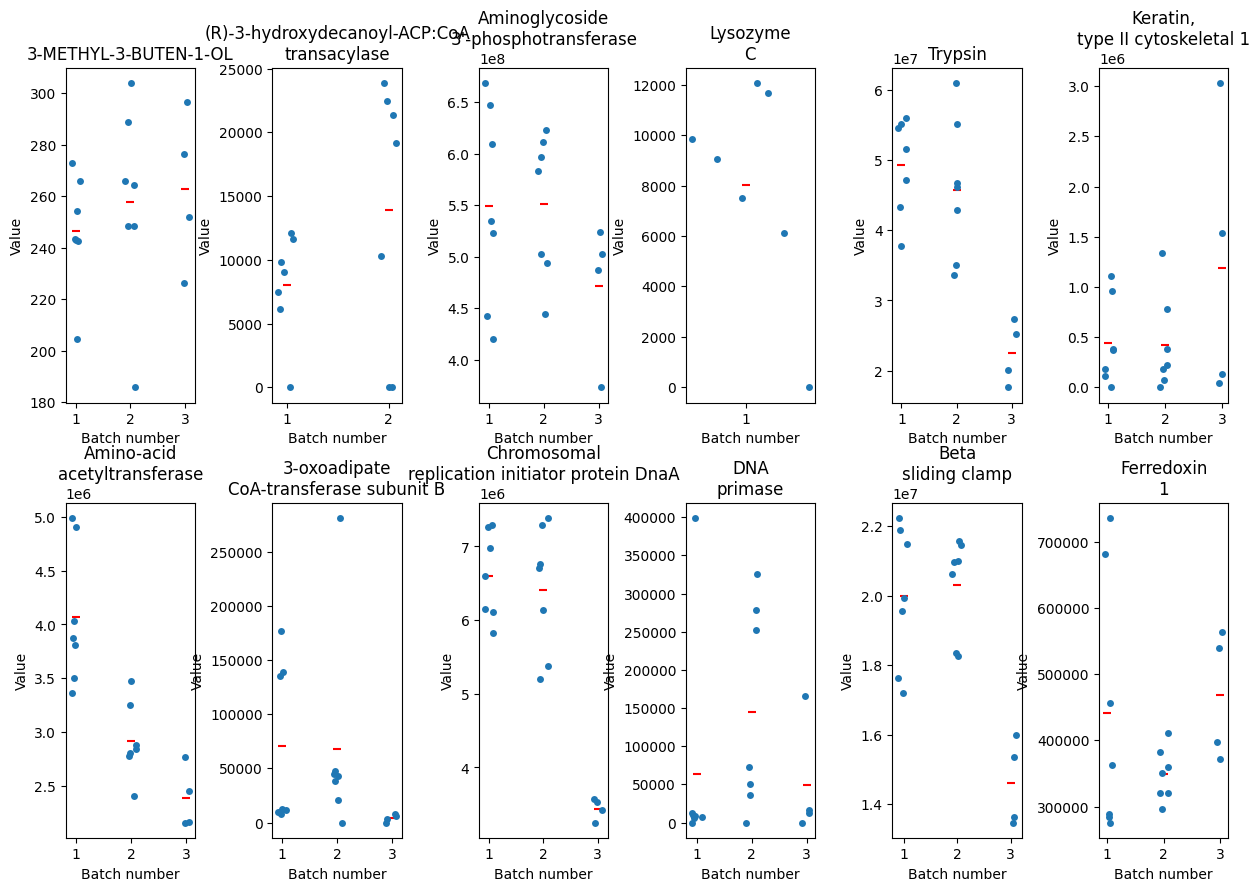

In [29]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch number'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch number', y = to_plot)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch number'] == batch_num)][to_plot]) for batch_num in batches]
                         
    _ = [ax.scatter(i, mean_vals[i], color = 'red', marker = '_') for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))

target_list_all = df_control['Measurement Type'].unique().tolist()
compare_swarm_multi(df_control, target_list_all[:12], [1,2,3])

### Test hypothesis that the last day had uniformly lower protein counts:
Our theory is that the detector became less sensitive over time. Thus, if you calculate $\Delta$(counts) for (day 3) - (day 1) most should be negative. We can also check (day 2) - (day 1). First, make a pivot table for measurements aggregated by $mean$, and drop NaN values.

In [30]:
#drop missing values from control_pivot_by_measurement
cntrl_pivot_by_measurement = pd.pivot_table(df_control, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
print(f'size of original pivot is: {cntrl_pivot_by_measurement.shape}')
cntrl_pivot_by_measurement_exist = cntrl_pivot_by_measurement.dropna()
print(f'size of drop-NaN pivot is: {cntrl_pivot_by_measurement_exist.shape} (after dropping proteomics measurements with any missing values in controls)')                                    

size of original pivot is: (2004, 3)
size of drop-NaN pivot is: (1732, 3) (after dropping proteomics measurements with any missing values in controls)


Next, check the distributions of changes:

[(-10000000.0, 10000000.0), (-10000000.0, 10000000.0)]

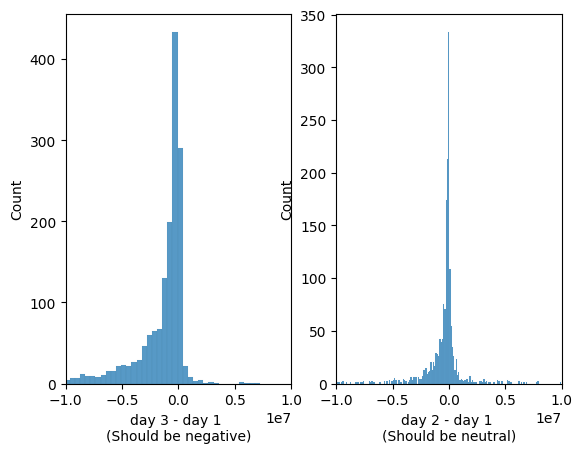

In [31]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between days.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax    
        
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['day 3 - day 1 \n(Should be negative)',
              'day 2 - day 1 \n(Should be neutral)']
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_exist, dif_to_plot, dif_labels)
ax_lim = 1e7
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
    

### 3. Normalize each run to the mean of that day's controls

- Drop measurement types missing from controls
- Calculate mean or median of control for each measurement type and day
- Add a column to df2 holding the day name



In [32]:
#Add batch number to df2 using find_expt_day() lambda function defined above
df2['Batch number'] = df2['Line Name'].apply(find_expt_day)
cntrl_pivot_by_measurement_exist = cntrl_pivot_by_measurement.dropna() 
list_of_control_measurements = cntrl_pivot_by_measurement_exist.index.values.tolist()
check_norm_exist = lambda x: 1 if x in list_of_control_measurements else 0
df_norm = df2.copy()
df_norm['can_normalize'] = df_norm['Measurement Type'].apply(check_norm_exist)
print(df_norm.head())
df_norm = df_norm[df_norm['can_normalize'] == 1]



         Line Name Line Description Protocol Formal Type  \
149130  PP_4549-R1     BL1A2_IY1586   GC-FID   cid:12988   
149131  PP_4550-R1     BL1A3_IY1587   GC-FID   cid:12988   
149132  PP_0368-R1     BL1A4_IY1588   GC-FID   cid:12988   
149133  PP_2136-R1     BL1A5_IY1589   GC-FID   cid:12988   
149134  PP_0774-R1     BL1A6_IY1590   GC-FID   cid:12988   

             Measurement Type     Value  Control  Batch number  can_normalize  
149130  3-METHYL-3-BUTEN-1-OL  298.9604    False             1              1  
149131  3-METHYL-3-BUTEN-1-OL  167.3975    False             1              1  
149132  3-METHYL-3-BUTEN-1-OL  340.5714    False             1              1  
149133  3-METHYL-3-BUTEN-1-OL  348.5097    False             1              1  
149134  3-METHYL-3-BUTEN-1-OL  215.1588    False             1              1  


Now that we have the data filtered by whether the corresponding proteomics data exists in the control data, we can normalize the data.

To do so:
- iterate through batch numbers
- create new lambda function to look for the control data from that batch number in the control data pivot table
- Apply lambda function to subset of the data from that batch to add control values




In [33]:
#Create a new column for the norm_value - this is the value to divide by in order to normalize
df_norm['control_val'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in range(1,4):
    #Create lambda function that references the proper column of the pivot table [1, 2, or 3]
    add_correct_normalization_value = lambda x: cntrl_pivot_by_measurement_exist[ii][x]
    #Apply lambda function to subset of df_norm that was run in that batch - Note: must use df_norm.loc[row, col] else dataframe won't be updated
    df_norm.loc[df_norm['Batch number']== ii, 'control_val'] = df_norm[df_norm['Batch number']== ii]['Measurement Type'].apply(add_correct_normalization_value)
    print(f'ii= {ii}, after updating there are {df_norm["control_val"].isna().sum()}/{len(df_norm)} NaN values left in df_norm')    
df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'Value']/df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'control_val']
df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'Value']
df_norm.head()
df_norm['norm_value']

ii= 1, after updating there are 750276/972228 NaN values left in df_norm
ii= 2, after updating there are 532836/972228 NaN values left in df_norm
ii= 3, after updating there are 0/972228 NaN values left in df_norm


149130     298.960400
149131     167.397500
149132     340.571400
149133     348.509700
149134     215.158800
              ...    
1182265      0.699447
1182266      0.659844
1182267      0.395660
1182268      0.257099
1182269      0.944223
Name: norm_value, Length: 972228, dtype: float64

## Check the value of the new normalized values.
Look at distributions of (day 3) - (day 1) and (day 2) - (day 1) for normalized data and compare with the unnormalized data.

First, need to make a pivot table with the normalized values.




In [34]:
cntrl_pivot_by_measurement_nonnorm = pd.pivot_table(df_norm, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
cntrl_pivot_by_measurement_norm = pd.pivot_table(df_norm, values = 'norm_value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)

### Distribution-of-differences plots 

[(-10000000.0, 10000000.0), (-10000000.0, 10000000.0)]

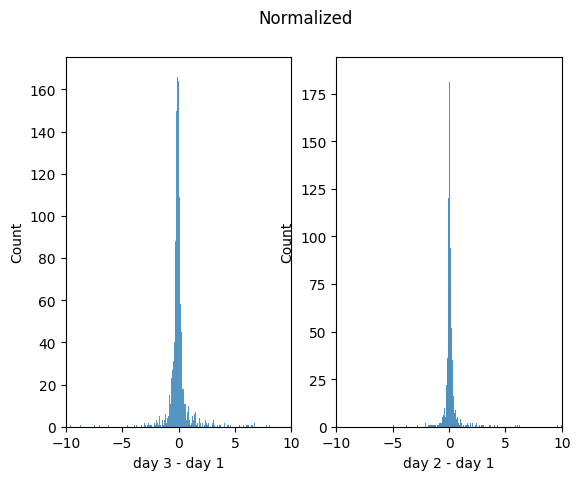

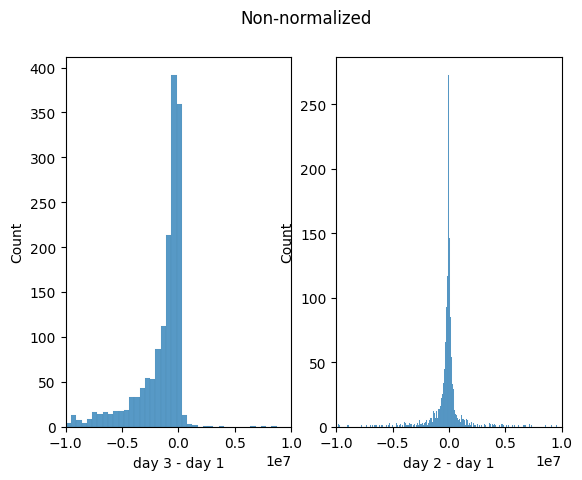

In [35]:
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['day 3 - day 1',
              'day 2 - day 1']
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_norm, dif_to_plot, dif_labels)
ax_lim = 10
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
fig.suptitle('Normalized')

ax_lim = 1e7
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_nonnorm, dif_to_plot, dif_labels)
fig.suptitle('Non-normalized')
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]



### Swarmplots for normalized values
These swarmplots compare the distribution of all proteins on each day before and after normalization. We can see that the normalization makes the difference in distributions much less. 



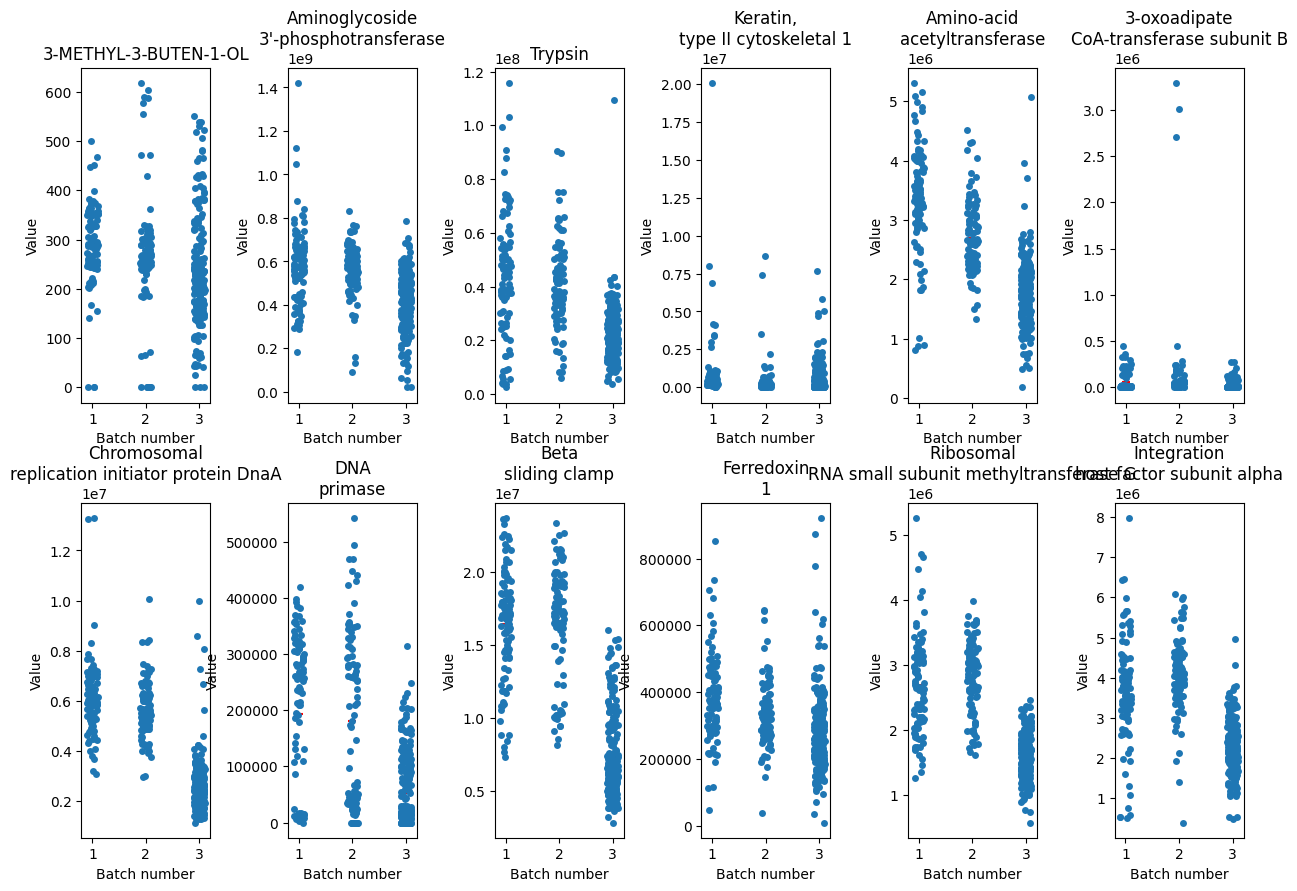

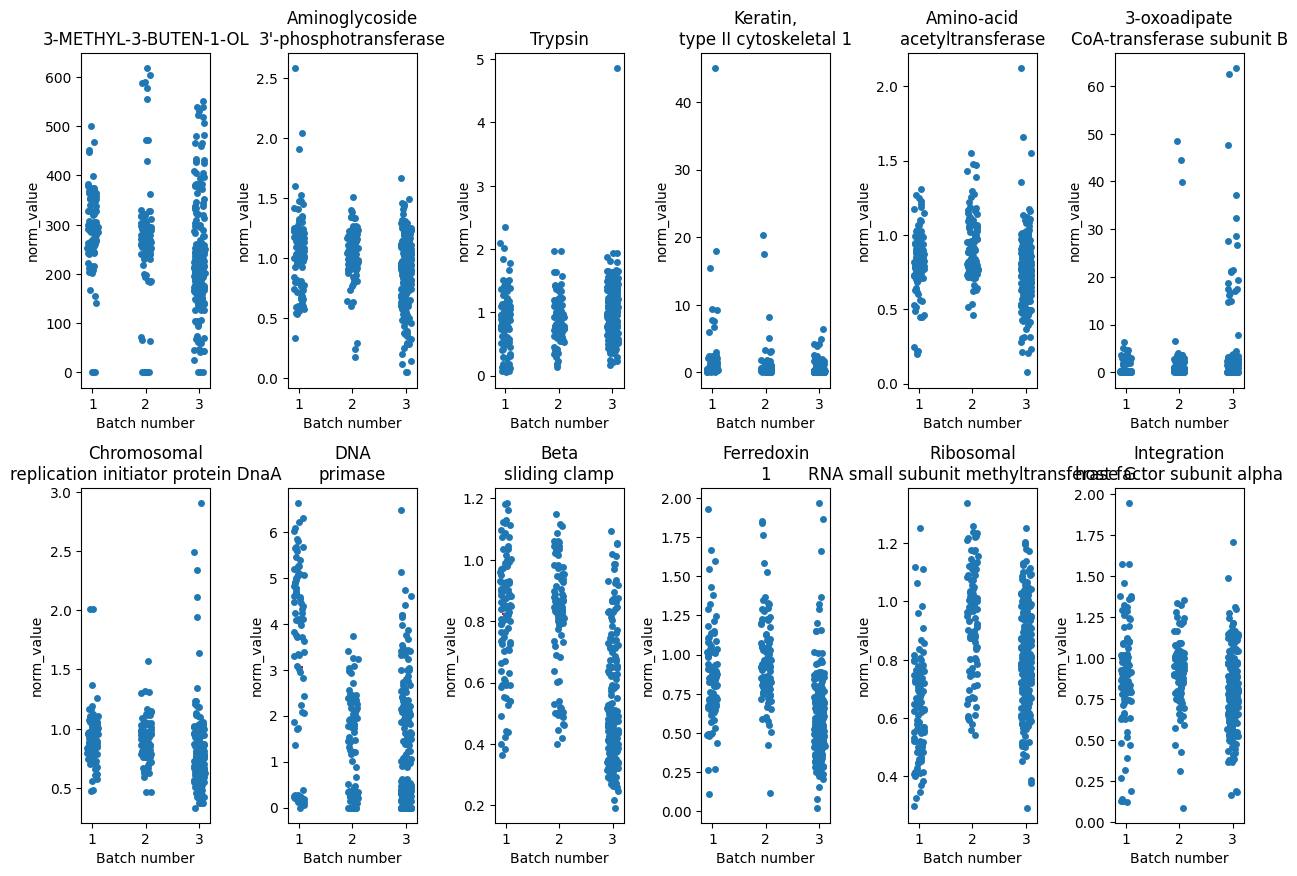

In [36]:
target_list_filter = df_norm['Measurement Type'].unique().tolist()

compare_swarm_multi(df_norm, target_list_filter[:12], [1,2,3], to_plot='Value')

compare_swarm_multi(df_norm, target_list_filter[:12], [1, 2, 3], to_plot='norm_value')


In [37]:
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588


## Check the efficacy of CRISPRi - preprocessing
Now that we have normalized the data, we can proceed with Hector's filtering of the proteomics data in order to check how CRISPi performed. To do so, we will:
1. Get Strain Names
2. Get uniprot names for proteins ('Formal Type') column in dataframe
3. Map uniprot IDs to protein names using provided spreadsheet
4. Drop the rows that are not in targets from the proteomics protocol:
5. Get target genes from 'Line_name' variable
6. Pivot to table with rows= Strain, columns = protein, values = normalized proteomics values
7. Do analysis on pivot table




In [38]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):
    "Choose recommended double and triple targets for CRISPRi knockdown"

    targets_list = list(df_targets['Target'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = tuple(sorted(random.sample(
            targets_list, counts=weights, k=size
        ))) # random sampling without replacement
        # new_target = sorted(random.choices(targets_list, weights=weights, k=size))
        # Check that the targets are not the same (sample function could provide repeated targets)
        # and if the combination was already chosen
        if len(set(new_target)) == size and new_target not in targets:
            targets.add(new_target)
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [39]:
 def plot_double_targets(targets_double, df_targets):
    "Plot double targets chosen with the function above"    
        
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Target'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [40]:
 def plot_triple_targets(targets_triple, df_targets):
    "Plot triple targets chosen with the function above"    
   
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Target']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

In [108]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value'):
    
    # Figure dimensions, color and label
    fig_height = 15
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    df_crispr.sort_values('Isoprenol mean', ascending=False, inplace=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3
                )

            # Add control
            plt.plot(df_targets.loc[control_strain, target], '.', color='k', markersize=10)

            # Add target
            data = df_targets[df_targets['Target']==target][target]
            if len(data)==1:
                plt.plot(data, marker='_', color=color, markersize=50, markeredgewidth=3)

            # Set y limits
            # ylim = np.max(df_targets[target]) + 50
            # ax.set_ylim([0, ylim])

        sns.despine(left=False, bottom=True)
        if save_name is None:
            save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
        if save:
            fig.savefig(
                save_name,
                transparent=True,
                bbox_inches="tight",
                dpi=300,
                )
    return fig, df_crispr

Print some information from dataframes - unique line descriptors, names, formal types, and Protocols. Also, check negative values - there shouldn't be any in proteomics data.

In [42]:

unique_line_desc = df_norm['Line Description'].unique()
print('Line descriptions length and unique entries')
print(len(unique_line_desc))
print(unique_line_desc[:20])

print('Line names length and unique entries')
unique_line_name = df_norm['Line Name'].unique()
print(len(unique_line_name))
print(unique_line_name[:20])

print('Formal Types length and unique entries')
unique_formal_types = df_norm['Formal Type'].unique()
print(len(unique_formal_types))
print(unique_formal_types[:20])

print('Unique protocols')
print(df_norm['Protocol'].unique())

print(f'There are {len(df_norm[df_norm["Value"]<0])} negative values in df_norm')

Line descriptions length and unique entries
420
['BL1A2_IY1586' 'BL1A3_IY1587' 'BL1A4_IY1588' 'BL1A5_IY1589'
 'BL1A6_IY1590' 'BL1A7_IY1591' 'BL1A8_IY1592' 'BL1B2_IY1586'
 'BL1B3_IY1587' 'BL1B4_IY1588' 'BL1B5_IY1589' 'BL1B6_IY1590'
 'BL1B7_IY1591' 'BL1B8_IY1592' 'BL1C2_IY1586' 'BL1C3_IY1587'
 'BL1C4_IY1588' 'BL1C5_IY1589' 'BL1C6_IY1590' 'BL1C7_IY1591']
Line names length and unique entries
420
['PP_4549-R1' 'PP_4550-R1' 'PP_0368-R1' 'PP_2136-R1' 'PP_0774-R1'
 'PP_0362-R1' 'PP_0437-R1' 'PP_4549-R2' 'PP_4550-R2' 'PP_0368-R2'
 'PP_2136-R2' 'PP_0774-R2' 'PP_0362-R2' 'PP_0437-R2' 'PP_4549-R3'
 'PP_4550-R3' 'PP_0368-R3' 'PP_2136-R3' 'PP_0774-R3' 'PP_0362-R3']
Formal Types length and unique entries
2416
['cid:12988' 'sp|P00552|KKA2_KLEPN Neo' 'sp|P00761|TRYP_PIG Trypsin'
 'sp|P04264' 'sp|P0A0Z9|ARGA_PSEPK Arga' 'sp|P0A101|PCAJ_PSEPK Pcaj'
 'sp|P0A116|DNAA_PSEPK Dnaa' 'sp|P0A118|DNAG_PSEPK Dnag'
 'sp|P0A120|DPO3B_PSEPK Dnan' 'sp|P0A122|FER1_PSEPK Fdxa'
 'sp|P0A124|RSMG_PSEPK Rsmg' 'sp|P0A126|IHF

### Add strain name to dataframe using prebuilt function.


In [43]:
df_norm["Strain"] = create_strain_names(df_norm)
print(df_norm.shape)

(972228, 12)


### Get Uniprot names

In [44]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)

get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'

print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


In [45]:
df_norm['Formal Type'] = df_norm['Formal Type'].apply(get_Uniprot)
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604,IY1586
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975,IY1587
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714,IY1588
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097,IY1589
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588,IY1590


In [46]:
print(df_norm.shape)

(972228, 12)


### Protein mapping using provided spreadsheet

In [47]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()


,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


limit CRISPRi target gene names to conventional gene names.

In [48]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])


### Protein-gene mapping sanity checks:
Need to check two things about protein-gene mapping:

- Are all of the target proteins still in the dataframe? Some could have been dropped if they could not be normalized.
- Is there a 1 to 1 correspondence between target genes and uniprot IDs?

First check if we dropped any target proteins.

In [49]:
#Create dataframe from full data and transform 'Formal Type' to get targets from full dataset
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)

targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
targets_in_df_norm = df_norm['Formal Type'].unique().tolist()
targets_in_df_full = df2['Formal Type'].unique().tolist()
print(f'There are {len(targets_in_mapping)} unique targets in xlsx file\n' 
        f'{len(targets_in_df_norm)} unique targets in norm dataframe\n'
        f'{len(targets_in_df_full)} unique targets in full dataframe')

targets_not_in_df_norm = [ii for ii in targets_in_mapping if ii not in targets_in_df_norm]
print('Targets in mapping that have been dropped from df_norm')
print(targets_not_in_df_norm)

targets_not_in_df_full = [ii for ii in targets_in_mapping if ii not in targets_in_mapping in targets_in_df_full]
print(f'There are {len(targets_not_in_df_full)} targets in map that are not in full dataframe')

There are 122 unique targets in xlsx file
2416 unique targets in norm dataframe
2696 unique targets in full dataframe
Targets in mapping that have been dropped from df_norm
['Q88QX2', 'Q88JR0', 'Q88GH9', 'Q88HG4', 'Q88HK1', 'Q88HS1', 'Q88N22', 'Q88HS3', 'Q88DT2', 'Q88QE6', 'P0A103', 'Q88PP2', 'Q88FG8', 'Q88FP6', 'Q88RM6', 'Q88RM5', 'Q88RM4', 'Q88RM3', 'Q88PN5', 'Q88PN4', 'Q88FD7', 'A0A140FWL1', 'Q88FD8', 'Q88R57', 'Q88E18', 'Q88RA8']
There are 0 targets in map that are not in full dataframe


Next check if there's a 1 to 1 correspondence in mapping. There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [50]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets have show up multiple times in the list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets have show up multiple times in the list:
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: CRISPRi target gene, dtype: int64
These Uniprot IDs show up multiple times
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: UNIPROT ID, dtype: int64


### Drop the rows that are not in targets from Proteomics protocol:

In [51]:
print(df_norm.shape)
df_norm = df_norm.drop(
                    index=df_norm[(~df_norm['Formal Type'].isin(targets_in_mapping)) &
                                  (df_norm['Protocol']=='Global Proteomics')].index)
print(df_norm.shape)
df_norm.tail()
len(df_norm)
df_norm

(972228, 12)
(40740, 12)


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,False,1,1,2.466806e+02,298.960400,IY1586
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,False,1,1,2.466806e+02,167.397500,IY1587
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,False,1,1,2.466806e+02,340.571400,IY1588
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,False,1,1,2.466806e+02,348.509700,IY1589
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,False,1,1,2.466806e+02,215.158800,IY1590
...,...,...,...,...,...,...,...,...,...,...,...,...
1164709,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q88RG2,Putative surface adhesion protein,1.098884e+07,False,3,1,5.121947e+06,2.145442,IY2022
1164710,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q88RG2,Putative surface adhesion protein,1.202594e+07,False,3,1,5.121947e+06,2.347923,IY2022
1164711,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q88RG2,Putative surface adhesion protein,5.613267e+06,False,3,1,5.121947e+06,1.095924,IY2019
1164712,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q88RG2,Putative surface adhesion protein,7.159665e+06,False,3,1,5.121947e+06,1.397840,IY2019


### Change names from Uniprot to PP_ names

In [52]:
protein_map = {}
for index in ProtMapping_df.index:
    protein_map[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

proteomics_ind = df_norm['Protocol']=='Global Proteomics'

df_norm.loc[proteomics_ind,'Formal Type'] = df_norm.loc[proteomics_ind,'Formal Type'].apply(lambda x: protein_map[x])

print(df_norm.shape)

(40740, 12)


### Add Target Gene
Add column with a target gene for each strain.

In [53]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

To get target gene:
 Input string: PP_4549-R1, output: PP_4549


In [54]:
df_norm['Target'] = df_norm['Line Name'].apply(get_target_gene)
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain,Target
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604,IY1586,PP_4549
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975,IY1587,PP_4550
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714,IY1588,PP_0368
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097,IY1589,PP_2136
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588,IY1590,PP_0774


## Statistical Analysis
### Pivot dataframe to table:

Pivot dataframe to table with strain as the row name, columns as the gene, and proteomics values as the value.

TODO next cell should be aggregating by norm_value not value


In [55]:
df_targets_norm = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "norm_value", aggfunc = np.mean)

df_targets = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "Value", aggfunc = np.mean)




In [56]:
df_targets.head()
df_targets_norm['cid:12988']=df_targets_norm['cid:12988']

In [57]:
df_targets_norm.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,3.671102,0.620934,1.081068,1.299539,0.095193,4.413050,...,2.075548,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111
IY1586,0.918049,1.305330,1.297028,0.876275,3.282608,1.151605,1.159695,1.046509,0.159640,5.248360,...,1.059699,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833
IY1587,0.628591,0.637950,0.630554,0.766956,2.785735,0.840861,0.922574,0.582428,0.183060,1.777312,...,0.840411,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567
IY1588,0.702731,1.628167,2.243601,1.175192,0.128151,0.994764,1.060118,0.876955,0.152259,3.819998,...,1.185321,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800
IY1589,0.958952,0.730286,0.738180,0.817158,15.571383,0.920269,1.251501,0.315354,0.135790,0.962319,...,0.864356,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900


Change compound ID to Isoprenol

In [58]:
df_targets_norm.rename(columns = {'cid:12988': 'Isoprenol mean'}, inplace = True)
df_targets_norm.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,3.671102,0.620934,1.081068,1.299539,0.095193,4.413050,...,2.075548,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111
IY1586,0.918049,1.305330,1.297028,0.876275,3.282608,1.151605,1.159695,1.046509,0.159640,5.248360,...,1.059699,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833
IY1587,0.628591,0.637950,0.630554,0.766956,2.785735,0.840861,0.922574,0.582428,0.183060,1.777312,...,0.840411,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567
IY1588,0.702731,1.628167,2.243601,1.175192,0.128151,0.994764,1.060118,0.876955,0.152259,3.819998,...,1.185321,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800
IY1589,0.958952,0.730286,0.738180,0.817158,15.571383,0.920269,1.251501,0.315354,0.135790,0.962319,...,0.864356,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900


Add the target genes to this table - create a map from the strains and targets in df_norm.

In [59]:
target_map = df_norm[['Strain', 'Target']].drop_duplicates().set_index("Strain")
target_map


,Target
Strain,
IY1586,PP_4549
IY1587,PP_4550
IY1588,PP_0368
IY1589,PP_2136
IY1590,PP_0774
...,...
IY2029,PP_4123
IY2032,PP_4128
IY2019,PP_5420


In [60]:
df_targets_norm.loc[target_map.index, 'Target'] = target_map['Target']
df_targets_norm.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,3.671102,0.620934,1.081068,1.299539,0.095193,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,3.282608,1.151605,1.159695,1.046509,0.159640,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,2.785735,0.840861,0.922574,0.582428,0.183060,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.128151,0.994764,1.060118,0.876955,0.152259,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,15.571383,0.920269,1.251501,0.315354,0.135790,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136


### Add stats to the targets dataframe 

Use previously defined function to add stats to pivot table.

In [61]:
df_targets_norm = find_library_stats(df_targets_norm)
df_targets_norm

/tmp/ipykernel_1043184/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1043184/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1043184/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1043184/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None


Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,3.671102,0.620934,1.081068,1.299539,0.095193,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,3.282608,1.151605,1.159695,1.046509,0.159640,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,2.785735,0.840861,0.922574,0.582428,0.183060,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.128151,0.994764,1.060118,0.876955,0.152259,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,15.571383,0.920269,1.251501,0.315354,0.135790,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,2.957842,1.000000,1.000000,1.000000,0.145834,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,254.648694,Control
Library_mean,0.971413,1.392877,0.990227,0.896029,2.524432,0.913986,1.098607,0.718635,0.097588,3.369946,...,0.928603,0.726279,1.242292,0.851511,1.005283,0.903975,1.020761,0.321725,NaN,NaN
Library_std,0.184909,0.823098,0.652679,0.140861,1.458303,0.341719,0.278543,0.900159,0.047226,4.914288,...,0.118924,0.309070,0.952425,0.307893,0.100187,0.129127,0.121520,0.333621,NaN,NaN


### Isoprenol production data

Find CV for isoprenol production.

In [62]:
df_isoprenol             = df_norm[df_norm['Measurement Type']=='3-METHYL-3-BUTEN-1-OL']
df_isoprenol             = df_isoprenol.drop(columns=['Line Name', 'Line Description', 'Measurement Type', 'Protocol','Control', 'Batch number', 'can_normalize'])
stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
stats_isoprenol.rename(columns={'Value': 'mean'}, inplace=True)
stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Value']
stats_isoprenol['CV[%]'] = 100* stats_isoprenol['std'] / stats_isoprenol['mean']
stats_isoprenol = stats_isoprenol.sort_values('CV[%]', ascending=False)
stats_isoprenol.head()

/tmp/ipykernel_1043184/1808311546.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
/tmp/ipykernel_1043184/1808311546.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Value']


,mean,control_val,norm_value,std,CV[%]
Strain,,,,,
IY2192,15.849800,262.882475,15.849800,27.452659,173.205081
IY1671,100.588117,260.397102,100.588117,110.470009,109.824115
IY2025,27.581113,262.882475,27.581113,23.906693,86.677767
IY2195,63.463733,262.882475,63.463733,39.644337,62.467704
IY1597,275.054650,254.781559,275.054650,93.993453,34.172646


Add these stats to the dataframe:

In [63]:
product = 'Isoprenol'
df_isoprenol.rename(columns={'Value': product}, inplace=True)
df_isoprenol = df_isoprenol.sort_values(product, ascending=False)
df_isoprenol['CV[%]'] = None

strains = [strain for strain in stats_isoprenol.index.unique()]
for strain in strains:
    index = df_isoprenol[df_isoprenol['Strain']==strain].index
    cv_value = stats_isoprenol[stats_isoprenol.index==strain]['CV[%]'].values
    df_isoprenol.loc[index, 'CV[%]'] = np.ones(len(index))*cv_value

df_isoprenol.drop(columns='Formal Type', inplace=True)
df_isoprenol.set_index("Strain", inplace=True)
df_targets_norm.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]


In [64]:
df_targets_norm



Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target,CV[%]
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,3.671102,0.620934,1.081068,1.299539,0.095193,4.413050,...,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607,20.218016
IY1586,0.918049,1.305330,1.297028,0.876275,3.282608,1.151605,1.159695,1.046509,0.159640,5.248360,...,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549,1.258797
IY1587,0.628591,0.637950,0.630554,0.766956,2.785735,0.840861,0.922574,0.582428,0.183060,1.777312,...,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550,8.410108
IY1588,0.702731,1.628167,2.243601,1.175192,0.128151,0.994764,1.060118,0.876955,0.152259,3.819998,...,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368,4.072284
IY1589,0.958952,0.730286,0.738180,0.817158,15.571383,0.920269,1.251501,0.315354,0.135790,0.962319,...,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136,0.74632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,2.957842,1.000000,1.000000,1.000000,0.145834,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,254.648694,Control,11.693238
Library_mean,0.971413,1.392877,0.990227,0.896029,2.524432,0.913986,1.098607,0.718635,0.097588,3.369946,...,0.726279,1.242292,0.851511,1.005283,0.903975,1.020761,0.321725,NaN,NaN,NaN
Library_std,0.184909,0.823098,0.652679,0.140861,1.458303,0.341719,0.278543,0.900159,0.047226,4.914288,...,0.309070,0.952425,0.307893,0.100187,0.129127,0.121520,0.333621,NaN,NaN,NaN


## Data Visualization
Visualize isoprenol production and CV.

In [65]:
df_isoprenol.head()

,Isoprenol,control_val,norm_value,Target,CV[%]
Strain,,,,,
IY2020,618.3056,257.911729,618.3056,PP_5419,5.359461
IY1688,603.9709,257.911729,603.9709,PP_0528,2.279287
IY1688,590.6272,257.911729,590.6272,PP_0528,2.279287
IY2020,587.8620,257.911729,587.8620,PP_5419,5.359461
IY1688,577.0506,257.911729,577.0506,PP_0528,2.279287


In [66]:
control_strain = df_norm.loc[df_norm['Control']==True,:]['Strain'].unique()[0]
df_control_stat = df_isoprenol.loc[control_strain]

/tmp/ipykernel_1043184/1113826032.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
/tmp/ipykernel_1043184/1113826032.py:55: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
/tmp/ipykernel_1043184/1113826032.py:73: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],


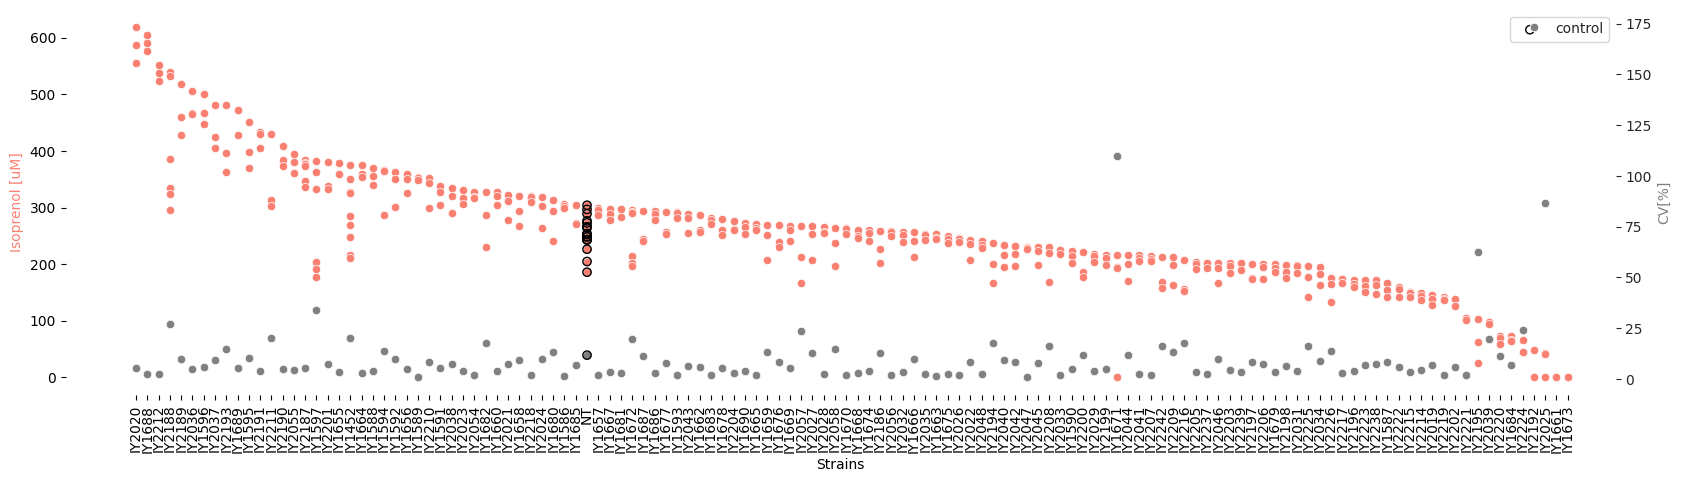

In [67]:
plot_titers(df_isoprenol, df_control_stat, 'Isoprenol')

Visualize distribution of proteomics levels in each strain (distributions) compared to the strain where that protein was targeted. 

In [110]:
sum(df_targets_norm['Target'] == 'PP_4194')
df_norm['Formal Type'].unique()

array(['cid:12988', 'PP_2471', 'PP_1506', 'PP_0001', 'PP_3365', 'PP_5419',
       'PP_5417', 'PP_5416', 'PP_5335', 'PP_5288', 'PP_5203', 'PP_5186',
       'PP_5128', 'PP_5064', 'PP_4894', 'PP_4862', 'PP_4702', 'PP_4679',
       'PP_4678', 'PP_4667', 'PP_4651', 'PP_4636', 'PP_4635', 'PP_4550',
       'PP_4549', 'PP_4487', 'PP_4266', 'PP_4194', 'PP_4193', 'PP_4192',
       'PP_4191', 'PP_4190', 'PP_4189', 'PP_4188', 'PP_4187', 'PP_4186',
       'PP_4185', 'PP_4175', 'PP_4174', 'PP_4130', 'PP_4129', 'PP_4123',
       'PP_4122', 'PP_4121', 'PP_4120', 'PP_4119', 'PP_4116', 'PP_4012',
       'PP_4011', 'PP_3755', 'PP_3754', 'PP_3578', 'PP_3123', 'PP_3122',
       'PP_3071', 'PP_2925', 'PP_2339', 'PP_2213', 'PP_2137', 'PP_2136',
       'PP_2112', 'PP_2095', 'PP_1777', 'PP_1770', 'PP_1769', 'PP_1755',
       'PP_1664', 'PP_1620', 'PP_1610', 'PP_1607', 'PP_1457', 'PP_1444',
       'PP_1319', 'PP_1318', 'PP_1317', 'PP_1251', 'PP_1240', 'PP_1031',
       'PP_1023', 'PP_0999', 'PP_0944', 'PP_0897'

['PP_0528', 'PP_5419', 'PP_4191', 'PP_4174', 'PP_4189', 'PP_1240', 'PP_1769', 'PP_0813', 'PP_1770', 'PP_0812', 'PP_0368', 'PP_2136', 'PP_1506', 'PP_4192', 'PP_0437', 'PP_4193', 'PP_5335', 'PP_0338', 'PP_0751', 'PP_4188', 'PP_5417', 'PP_4549', 'PP_0168', 'PP_3755', 'PP_4487', 'PP_2213', 'PP_2137', 'PP_2471', 'PP_3071', 'PP_4667', 'PP_1457', 'PP_3754', 'PP_3122', 'PP_4636', 'PP_4702', 'PP_3365', 'PP_4122', 'PP_4175', 'PP_3578', 'PP_1664', 'PP_4678', 'PP_0582', 'PP_0597', 'PP_5288', 'PP_1444', 'PP_4120', 'PP_4121', 'PP_1318', 'PP_0691', 'PP_1319', 'PP_5416', 'PP_1317', 'PP_0999', 'PP_4862', 'PP_4187', 'PP_4116', 'PP_0774', 'PP_4123', 'PP_0226', 'PP_4651', 'PP_4635', 'PP_1023', 'PP_5203', 'PP_2095', 'PP_0658', 'PP_4266', 'PP_3123', 'PP_4130', 'PP_1031', 'PP_4185', 'PP_1755', 'PP_0654', 'PP_5186', 'PP_4011', 'PP_5128', 'PP_4186', 'PP_4550', 'PP_2339', 'PP_0944', 'PP_0897', 'PP_2925', 'PP_1620', 'PP_2112', 'PP_4679', 'PP_0001', 'PP_1251', 'PP_4894', 'PP_1610', 'PP_4012', 'PP_4119', 'PP_5064'

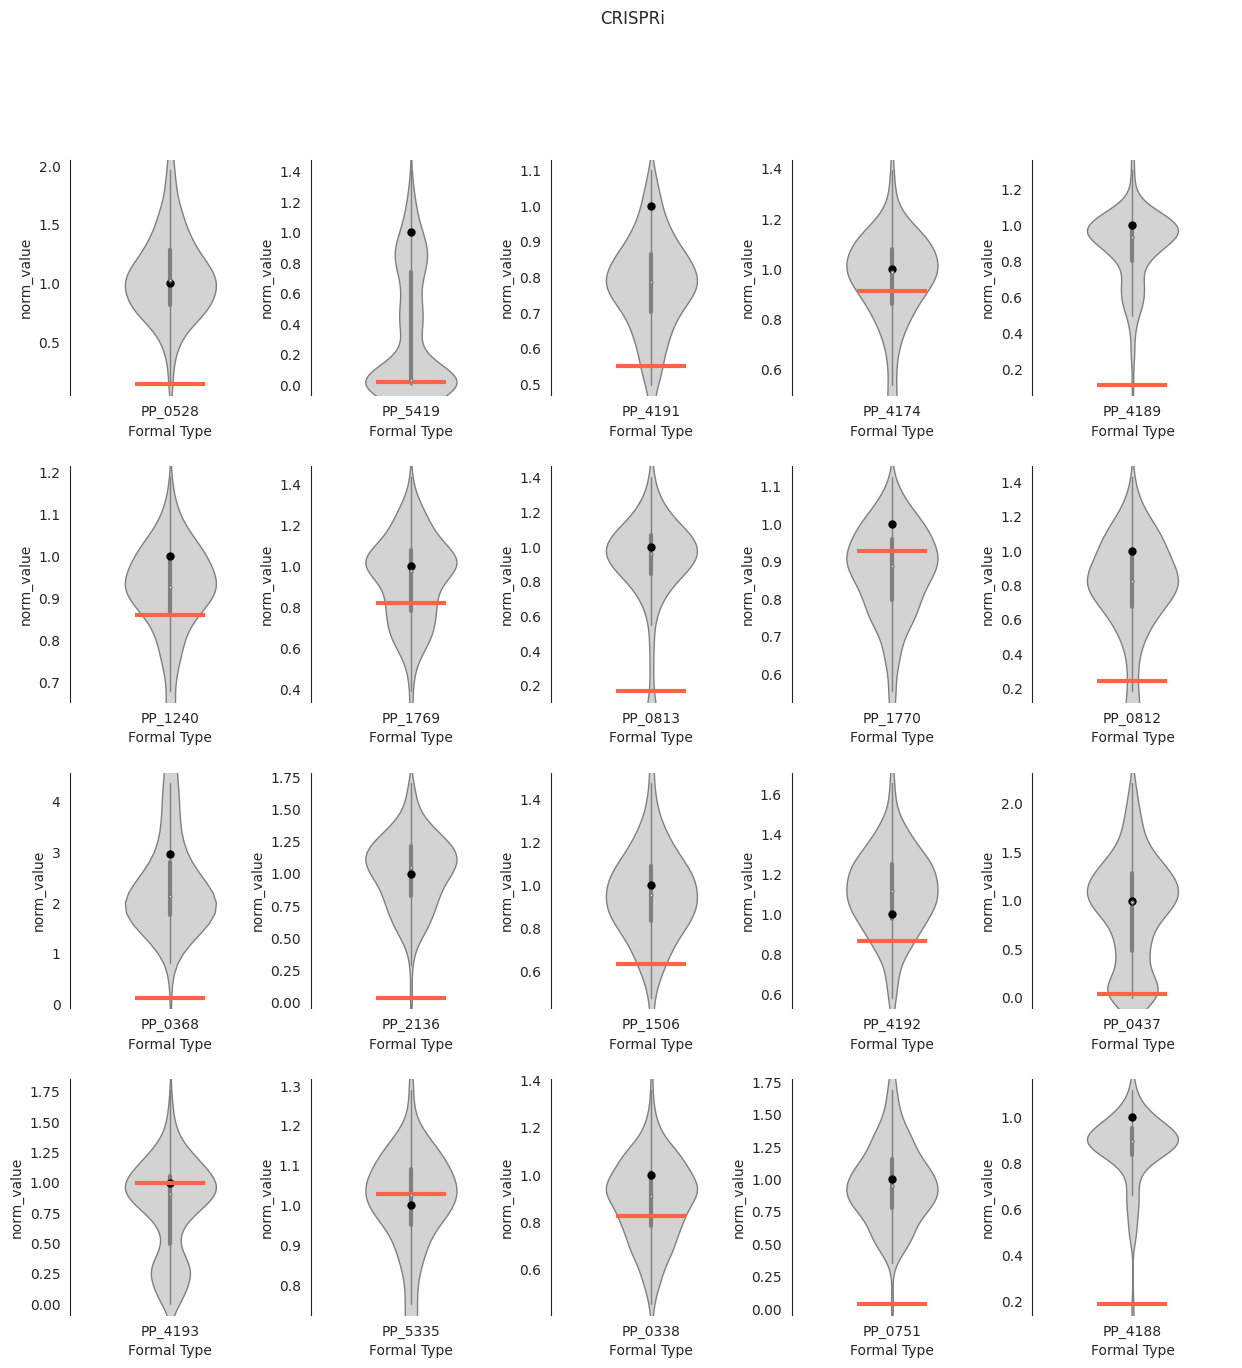

In [114]:
df_crispr = df_targets_norm.loc[df_targets_norm['Isoprenol mean'].dropna().index,:]
df_crispr.sort_values("Isoprenol mean", ascending = False, inplace = True)
    

targets_all = list(df_crispr['Target'].values)
targets_filter = []
for tt in targets_all:
    if (sum(df_targets_norm['Target'] == tt) == 1) and (tt in df_norm['Formal Type'].unique()):
        targets_filter.append(tt)
print(targets_filter)
targetsP = targets_filter[:20]

fig = plot_crispr_library(df_norm, df_targets_norm, targetsP, save=False, violin_field='norm_value')


## Make Recommendations - Selecting Target Genes
Criteria for downselection:

Transcription value for the CRISPRi targeted gene:
Within the bottom 25th percentile of the library
More than 25% lower than the mean of the library

### Calculate ratios

We calculate the ratios of the target protein concentration to the control, library mean, Q1 and Q3 (eliminating the strain with the target gene):

In [115]:
df_targets_norm = find_fold_changes(df_targets_norm)
df_targets_norm

Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5417,PP_5419,Isoprenol mean,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,3.671102,0.620934,1.081068,1.299539,0.095193,4.413050,...,0.937266,0.600624,289.814111,PP_1607,20.218016,0.835546,0.895268,0.950706,0.837033,-0.859869
IY1586,0.918049,1.305330,1.297028,0.876275,3.282608,1.151605,1.159695,1.046509,0.159640,5.248360,...,1.046875,0.346177,302.681833,PP_4549,1.258797,0.051181,0.073447,0.088091,0.062293,-3.672694
IY1587,0.628591,0.637950,0.630554,0.766956,2.785735,0.840861,0.922574,0.582428,0.183060,1.777312,...,0.995729,0.162470,154.452567,PP_4550,8.410108,0.806427,0.271305,1.172693,0.283344,-0.325976
IY1588,0.702731,1.628167,2.243601,1.175192,0.128151,0.994764,1.060118,0.876955,0.152259,3.819998,...,1.002899,0.854964,355.020800,PP_0368,4.072284,0.043326,0.050764,0.071139,0.04522,-1.643198
IY1589,0.958952,0.730286,0.738180,0.817158,15.571383,0.920269,1.251501,0.315354,0.135790,0.962319,...,0.987194,0.711793,351.199900,PP_2136,0.74632,0.036127,0.03451,0.040185,0.031508,-3.533457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,2.957842,1.000000,1.000000,1.000000,0.145834,1.000000,...,1.000000,1.000000,254.648694,Control,11.693238,None,None,None,None,None
Library_mean,0.971413,1.392877,0.990227,0.896029,2.524432,0.913986,1.098607,0.718635,0.097588,3.369946,...,1.020761,0.321725,NaN,NaN,NaN,None,None,None,None,None
Library_std,0.184909,0.823098,0.652679,0.140861,1.458303,0.341719,0.278543,0.900159,0.047226,4.914288,...,0.121520,0.333621,NaN,NaN,NaN,None,None,None,None,None


In [116]:
cols = [
    'Target',
    'Isoprenol mean','CV[%]',
    'Target:Control','Target:Library_mean',
    'Target:Library_Q1','Target:Library_Q3'
]
df_filtering = df_targets_norm.loc[strains][cols]
df_filtering

Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY2192,PP_5064,15.849800,173.205081,0.979425,0.831695,1.174694,0.750364
IY1671,PP_4679,100.588117,109.824115,0.442137,0.681011,0.866659,0.553459
IY2025,PP_4119,27.581113,86.677767,0.176541,0.183362,0.212926,0.155034
IY2195,PP_1610,63.463733,62.467704,0.644333,0.794981,0.88753,0.714991
IY1597,PP_1607,275.054650,34.172646,None,None,None,None
...,...,...,...,...,...,...,...
IY1586,PP_4549,302.681833,1.258797,0.051181,0.073447,0.088091,0.062293
IY2047,PP_1317,228.187567,0.790181,0.016678,0.013555,0.016637,0.012274
IY1589,PP_2136,351.199900,0.74632,0.036127,0.03451,0.040185,0.031508


(65, 7)


Text(0.5, 0.98, 'Comparing distributions stats and thresholds')

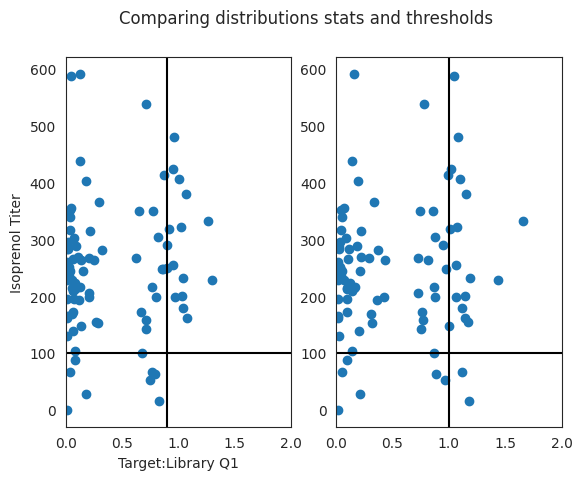

In [174]:
mean_thresh = 0.9
q1_thresh = 1
df_selection = df_filtering.loc[(
        (df_filtering['Target:Library_mean']<mean_thresh) &
        (df_filtering['Target:Library_Q1']<q1_thresh)
)
     & (df_filtering['Isoprenol mean']>100)
,:]
print(df_selection.shape)
df_selection.head()



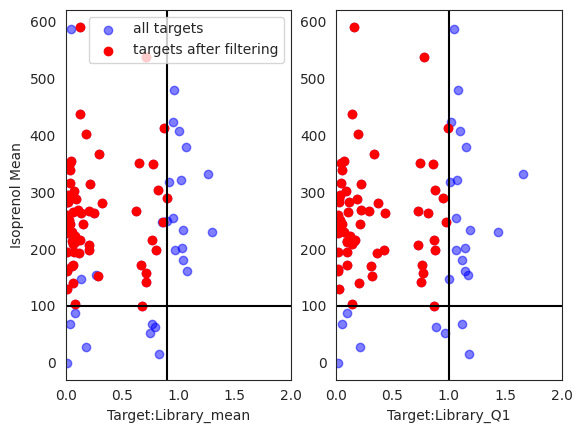

In [185]:
def plot_filter_results(df_all, df_filter, horiz_thresh, vert_thresh, x_fields):
    n_plots = len(x_fields)
    fig,ax = plt.subplots(1,n_plots)
    
    for ii in range(n_plots):
        ax[ii].scatter(df_all[x_fields[ii]], df_all['Isoprenol mean'], color = 'blue', alpha = 0.5, label = 'all targets')
        ax[ii].scatter(df_filter[x_fields[ii]], df_filter['Isoprenol mean'], color = 'red', label = 'targets after filtering')
        ax[ii].set_xlim([0, 2])
        ax[ii].axvline(vert_thresh[ii], color = 'k')
        ax[ii].axhline(horiz_thresh[ii], color = 'k')
        ax[ii].set_xlabel(x_fields[ii])
        if ii == 0:
            ax[ii].set_ylabel('Isoprenol Mean')
            ax[ii].legend()
    return fig

f = plot_filter_results(df_filtering, df_selection, 
                        [100, 100], [mean_thresh, q1_thresh],
                        ['Target:Library_mean', 'Target:Library_Q1'])
f.savefig(f"{user_params['output_dir']}/target_filter_results.png",
          transparent = True,
          bbox_inches = 'tight',
          dpi = 300,
         )
    
    




In [135]:
gene_targets= df_selection["Target"].tolist()
print(str(len(gene_targets))+ " gene targets:")
print(gene_targets)
print(f'Max isoprenol in df selection {max(df_selection["Isoprenol mean"])}')


58 gene targets:
['PP_4679', 'PP_0813', 'PP_1755', 'PP_2471', 'PP_4185', 'PP_4651', 'PP_4186', 'PP_2137', 'PP_1444', 'PP_4121', 'PP_1319', 'PP_0658', 'PP_0437', 'PP_0168', 'PP_4189', 'PP_4116', 'PP_0597', 'PP_4862', 'PP_4667', 'PP_1506', 'PP_4188', 'PP_4011', 'PP_2213', 'PP_3071', 'PP_2339', 'PP_1620', 'PP_0812', 'PP_3122', 'PP_0774', 'PP_4266', 'PP_0897', 'PP_0368', 'PP_5186', 'PP_4636', 'PP_3578', 'PP_4123', 'PP_3123', 'PP_3755', 'PP_5203', 'PP_1457', 'PP_4487', 'PP_0654', 'PP_1318', 'PP_4191', 'PP_5288', 'PP_0528', 'PP_4122', 'PP_2925', 'PP_0999', 'PP_0751', 'PP_3365', 'PP_3754', 'PP_2112', 'PP_0226', 'PP_4120', 'PP_4549', 'PP_1317', 'PP_2136']
Max isoprenol in df selection 590.5495666666667
Max isoprenol in df targets 590.5495666666667


In [136]:
user_params['n_instances_double'] = 25
user_params['n_instances_triple'] = 25
user_params['n_replicates'] = 3 
df_targets2 = df_selection[["Target","Isoprenol mean"]]
df_targets2.columns.name=''
df_targets2

,Target,Isoprenol mean
Strain,,
IY1671,PP_4679,100.588117
IY2188,PP_0813,401.706750
IY2216,PP_1755,172.138800
IY1682,PP_2471,281.494767
IY2225,PP_4185,172.424043
IY2208,PP_4651,206.139823
IY2226,PP_4186,158.079290
IY1680,PP_2137,282.547000
IY1659,PP_1444,243.303000


In [138]:
control_production = df_targets_norm.loc["NT",'Isoprenol mean']
df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production
df_targets2

/tmp/ipykernel_1043184/4108564400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production


,Target,Isoprenol mean,Ratio
Strain,,,
IY1671,PP_4679,100.588117,0.395007
IY2188,PP_0813,401.706750,1.577494
IY2216,PP_1755,172.138800,0.675985
IY1682,PP_2471,281.494767,1.105424
IY2225,PP_4185,172.424043,0.677106
IY2208,PP_4651,206.139823,0.809507
IY2226,PP_4186,158.079290,0.620774
IY1680,PP_2137,282.547000,1.109556
IY1659,PP_1444,243.303000,0.955446


As ratios go from very close to zero to around 1, we will add a factor (e.g. 5) to all of the targets so to have a non-zero probability to sample each of the targets.

In [139]:
df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)
df_targets2 = df_targets2.astype({'Weight': 'int'})
df_targets2

/tmp/ipykernel_1043184/2229913683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)


,Target,Isoprenol mean,Ratio,Weight
Strain,,,,
IY1671,PP_4679,100.588117,0.395007,9
IY2188,PP_0813,401.706750,1.577494,21
IY2216,PP_1755,172.138800,0.675985,12
IY1682,PP_2471,281.494767,1.105424,16
IY2225,PP_4185,172.424043,0.677106,12
IY2208,PP_4651,206.139823,0.809507,13
IY2226,PP_4186,158.079290,0.620774,11
IY1680,PP_2137,282.547000,1.109556,16
IY1659,PP_1444,243.303000,0.955446,15


And we get rid of the ratio, since we use the weight column to choose doubles and triples:

In [140]:
df_targets2 = df_targets2[['Target', 'Isoprenol mean','Weight']]
n_targets = len(df_targets2['Target'])
df_targets2.head()



,Target,Isoprenol mean,Weight
Strain,,,
IY1671,PP_4679,100.588117,9
IY2188,PP_0813,401.706750,21
IY2216,PP_1755,172.138800,12
IY1682,PP_2471,281.494767,16
IY2225,PP_4185,172.424043,12


### Check correlation between target selection and titer

Select a bunch of single targets (so that repeats don't affect picks) and plot their occurence vs. titer.

Text(0.5, 1.0, 'With weighting')

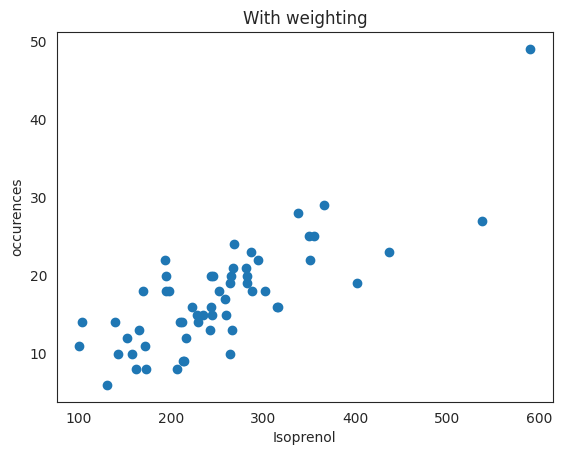

In [141]:
#Get random individual picks
targets_test = []
targets_test_nowt = []
for ii in range(1000):
    target_test = choose_targets(df_targets2, size = 1, weighting=True, n_instances=1)
    target_test_nowt = choose_targets(df_targets2, size = 1, weighting=False, n_instances=1)
    targets_test.append(target_test[0][0])
#Get unique
df_targets_test = df_targets2.copy()
df_targets_test['occurences'] = 0
count_occurences = lambda x: targets_test.count(x)
df_targets_test['occurences'] = df_targets_test['Target'].apply(count_occurences)
df_targets_test.head()
fig, ax = plt.subplots(1,1)
ax.scatter(df_targets_test['Isoprenol mean'], df_targets_test['occurences'])
plt.xlabel('Isoprenol')
plt.ylabel('occurences')
plt.title('With weighting')



In [ ]:
list(np.unique(targets_test))

### Choose double targets

We now choose double targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [ ]:
targets_double = choose_targets(
    df_targets2, 
    size=2, 
    n_instances= user_params['n_instances_double'],
    verbose=1
)

for target in targets_double:
    print(target)
    
#Save to file: 
with open(user_params['double_targets_file'], mode="wt") as f:
    for target in targets_double:
        f.write(str(target))
        
plot_double_targets(targets_double, df_targets2)


### Choose triple targets

As for the case of double targets, we choose triple targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [ ]:
targets_triple = choose_targets(
    df_targets2, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
)

print(targets_triple)

plot_triple_targets(targets_triple, df_targets2)

with open(user_params['triple_targets_file'], mode="wt") as f:
    for target in targets_triple:
        f.write(str(target))

## Visualize recommendations:
Make violin plots of the most common recommendations and all of the potential recommendations.


In [ ]:
#previous code:
"""
targetsP = list(df_targets.columns.values[:-3])
targetsP = targetsP[:20]
print(targetsP)
df_targets
plot_crispr_library(df_norm, df_targets, targetsP)
"""

#Identify highest N producers - get a list of isoprenol means and targets, drop the NaNs, and sort by 
sorted_filtered_targets = df_targets2.loc[:, ['Isoprenol mean', 'Target']].dropna().sort_values('Isoprenol mean', ascending = False)
high_producers = list(sorted_filtered_targets.loc[:, 'Target'].values[:20])
#Alter the save_name so that we don't overwrite the other image
save_name_highprod = f"{user_params['output_dir']}/crispri_high_producers.png"
plot_crispr_library(df_norm, df_targets, high_producers, save = True, save_name = save_name_highprod)
            

